# Detección Automática de Críticas Negativas en IMDB

# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

**Instrucciones del proyecto:** 
1. Carga los datos.
2. Preprocesa los datos, si es necesario.
3. Realiza un análisis exploratorio de datos y haz tu conclusión sobre el desequilibrio de clases.
4. Realiza el preprocesamiento de datos para el modelado.
5. Entrena al menos tres modelos diferentes para el conjunto de datos de entrenamiento.
6. Prueba los modelos para el conjunto de datos de prueba.
7. Escribe algunas reseñas y clasifícalas con todos los modelos.
8. Busca las diferencias entre los resultados de las pruebas de los modelos en los dos puntos anteriores. Intenta explicarlas.
9. Muestra tus hallazgos

**DESCRIPCIÓN DEL ARCHIVO** 

El archivo a analizar para este proyecto se almacena en `imdb_reviews.tsv`. En el cual los datos fueron proporcionados por Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, y Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. La Reunión Anual 49 de la Asociación de Lingüística Computacional (ACL 2011).

Los campos seleccionados para este analisis son los siguientes:

* `review`: Es el texto de la reseña
* `pos`: Es el objetivo. En el cual  '0' para negativo y '1' para positivo
* `ds_part`: 'entrenamiento'/'prueba' para la parte de entrenamiento/prueba del conjunto de datos, respectivamente

## Inicialización

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm


import re

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

print(f'\n Datos cargados correctamente. Con la siguiente dimensión:{df_reviews.shape}')


 Datos cargados correctamente. Con la siguiente dimensión:(47331, 17)


In [5]:
print("\nInformación general del DataFrame")
df_reviews.info()
print("\n Estadísitica descriptiva")
df_reviews.describe()


Información general del DataFrame
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


In [6]:
#Obtención de las 10 primeras filas de las bases de datos 
df_reviews.head(10)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281
5,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,This is the first movie I've seen from Singapo...,9,pos,1,test,9282
6,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Yes non-Singaporean's can't see what's the big...,9,pos,1,test,9283
7,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,This true story of Carlson's Raiders is more o...,2,neg,0,train,9903
8,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,Should have been titled 'Balderdash!' Little i...,2,neg,0,train,9905
9,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,The movie 'Gung Ho!': The Story of Carlson's M...,4,neg,0,train,9904


**NOTA GENERAL** 
* El DataFrame tiene un dimensión de (47331, 17). 
* Las reseñas de las películas van desde 1894 a 2010 
* La calificación máxima que puede obtener un película es 10 y la mínima es 1.
* El rating va desde 1.4 a 9.7 


## EDA

Veamos el número de películas y reseñas a lo largo de los años.

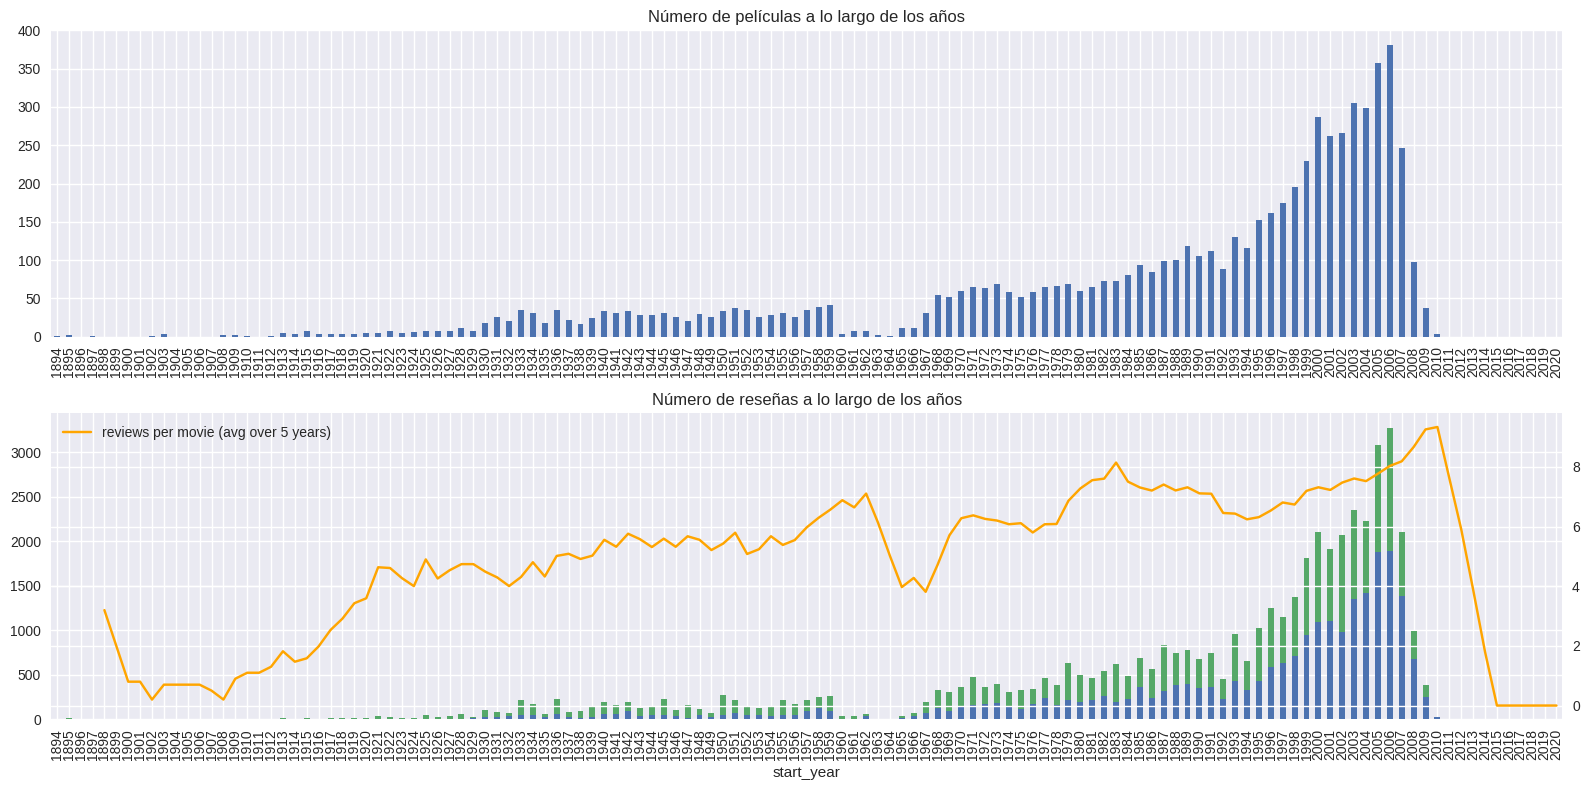

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

En esta gráfica se puede visualizar el comienzo de la reseñas de las películas comienzn desde 1899 hasta el año 2010. En el cual se puede visualizar que con el transcurso de los años, comenzaron a salir más peliculas y con este las reseñas se volvieron cruciales para las películas. 

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

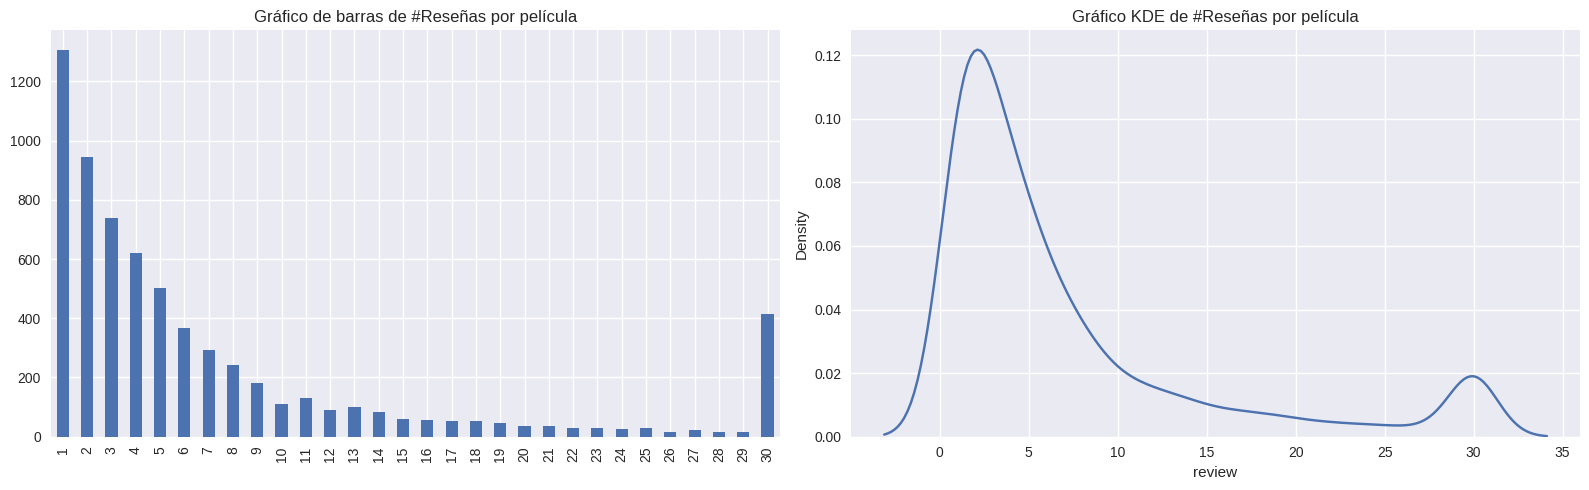

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

La distribución de reseñas por película es asimétrica y está concentrada en valores bajos, con un pequeño grupo de películas que tienen muchas reseñas, probablemente por ser más populares o estar limitadas en cantidad máxima de evaluaciones.

In [9]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

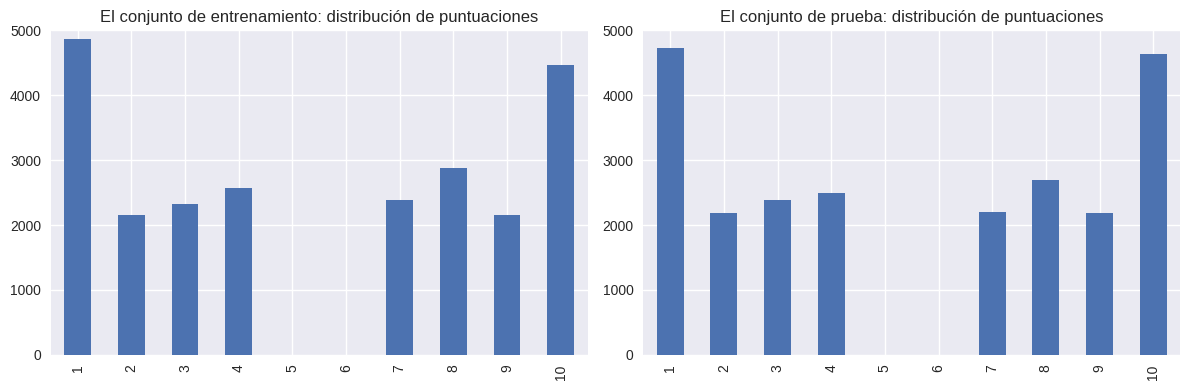

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

La distribución entre el conjunto de pruebas y de entrenamiento tienen el mismo comportamineto. Significa que tienen la misma dimensión de valores. 

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


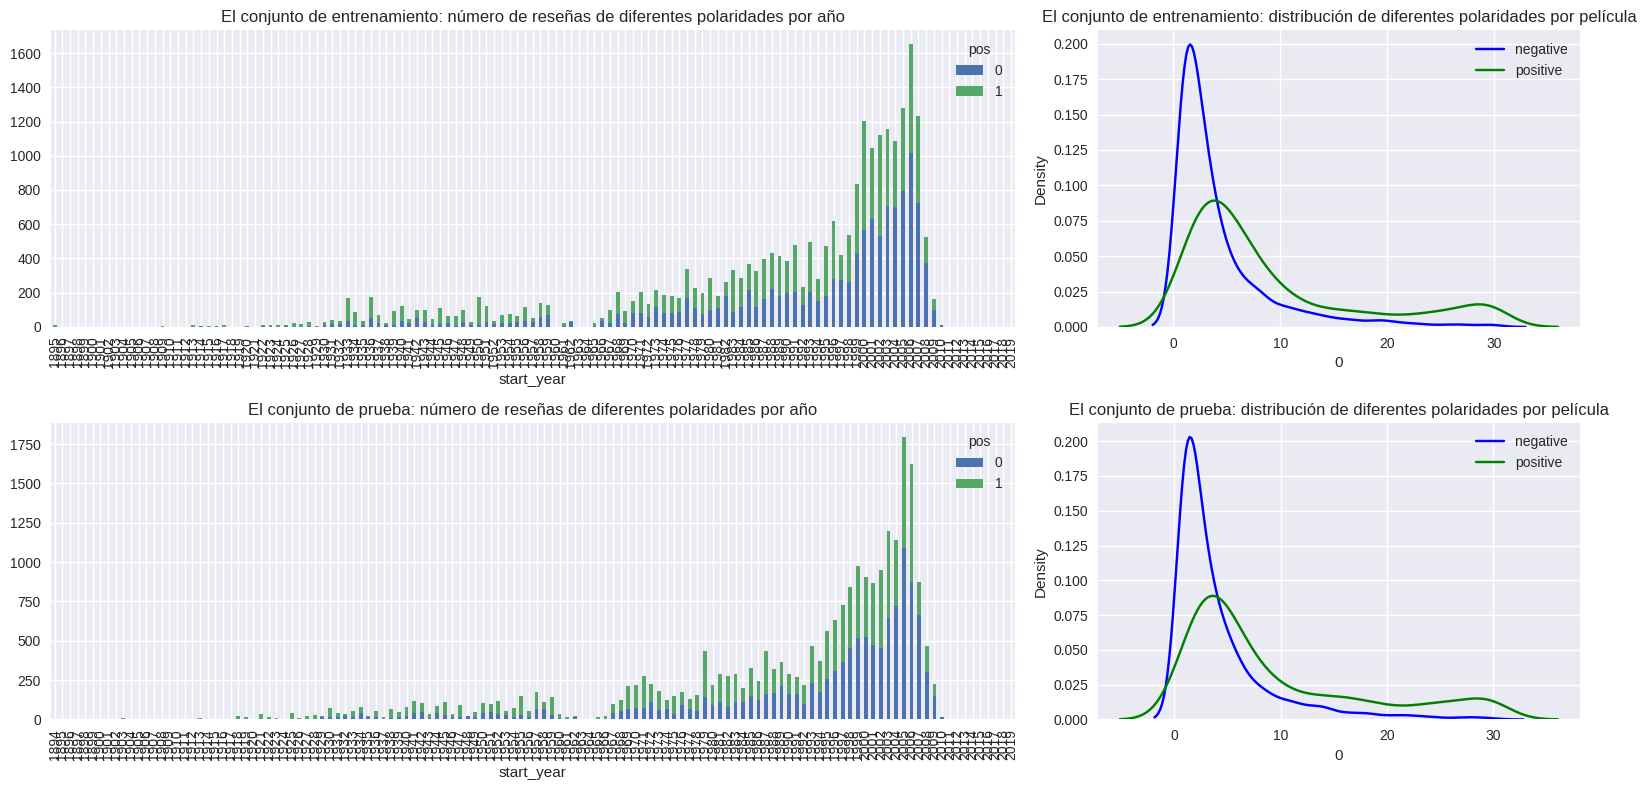

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [12]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [13]:
def  normalization_text(text):
    #El proposito de esto es transforma un texto. En donde se devolvera el texto en minúsculas
    # y solamente con letras y apóstrofes.
    
    pattern = r"[^a-z']"
    text = re.sub(pattern, " ", text.lower()).split()
    return " ".join(text)

In [14]:
# Creación de  una columna con las reviews normaliza
df_reviews['review_norm'] = df_reviews['review'].apply(normalization_text)

#Visualización de los cambios y se escogera 10
df_reviews[['review', 'review_norm']].head(10)

,review,review_norm
0,The pakage implies that Warren Beatty and Gold...,the pakage implies that warren beatty and gold...
1,How the hell did they get this made?! Presenti...,how the hell did they get this made presenting...
2,There is no real story the film seems more lik...,there is no real story the film seems more lik...
3,Um .... a serious film about troubled teens in...,um a serious film about troubled teens in sing...
4,I'm totally agree with GarryJohal from Singapo...,i'm totally agree with garryjohal from singapo...
5,This is the first movie I've seen from Singapo...,this is the first movie i've seen from singapo...
6,Yes non-Singaporean's can't see what's the big...,yes non singaporean's can't see what's the big...
7,This true story of Carlson's Raiders is more o...,this true story of carlson's raiders is more o...
8,Should have been titled 'Balderdash!' Little i...,should have been titled 'balderdash ' little i...
9,The movie 'Gung Ho!': The Story of Carlson's M...,the movie 'gung ho ' the story of carlson's ma...


## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [15]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Trabajar con modelos

### Modelo 0 - Constante

In [16]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report

In [17]:
# Inicializar el modelo dummy y entrenarlo. 
dummy_clf = DummyClassifier(strategy='uniform', random_state=42)
dummy_clf.fit(df_reviews_train, train_target)

DummyClassifier(random_state=42, strategy='uniform')

In [18]:
dummy_pred = dummy_clf.predict(df_reviews_test)

# Imprimir el accuracy score
print("Accuracy:", accuracy_score(test_target, dummy_pred))

# Print classification reports
print("\nClassification Report:")
print(classification_report(test_target, dummy_pred))

Accuracy: 0.5015933715742511

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50     11803
           1       0.50      0.50      0.50     11732

    accuracy                           0.50     23535
   macro avg       0.50      0.50      0.50     23535
weighted avg       0.50      0.50      0.50     23535



           train  test
Exactitud    NaN   NaN
F1          0.51   0.5
APS         0.50   0.5
ROC AUC     0.50   0.5


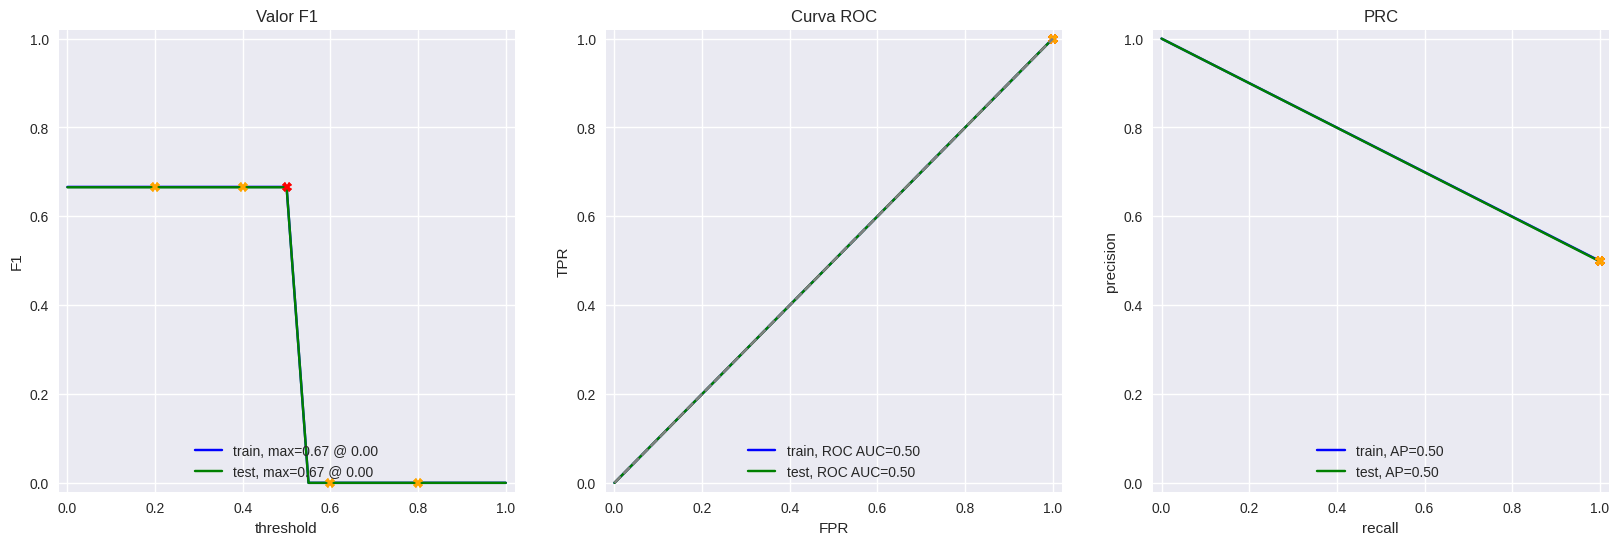

In [19]:
# Evaluar el modelo para F1, APS, ROC-AUC
evaluate_model(dummy_clf, df_reviews_train, train_target, df_reviews_test, test_target)

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [20]:
import nltk


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [21]:
# definir las palabras vacías
stop_words = set(stopwords.words('english'))

#Configurar el vectorizador TF-IDF y pasar las palabras irrelevantes
# En donde el vectorizador convierte texto en una representación numérica basada en TF-IDF
tfid_vectorizer = TfidfVectorizer(stop_words = stop_words, lowercase=True)

# Transformar los datos de entrenamiento y prueba

train_features_1 = tfid_vectorizer.fit_transform(df_reviews_train['review_norm'])

test_features_1 = tfid_vectorizer.transform(df_reviews_test["review_norm"])

# Mostrar las dimensiones de los conjuntos transformados
print(f'El tamaño de train_features es: {train_features_1.shape}')
print(f'El tamaño de test_features es: {test_features_1.shape}')

El tamaño de train_features es: (23796, 71531)
El tamaño de test_features es: (23535, 71531)


In [22]:
#Entrenamiento y ajueste del modelo 
model_1 = LogisticRegression()
model_1.fit(train_features_1, train_target)

LogisticRegression()

           train  test
Exactitud    NaN   NaN
F1          0.94  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


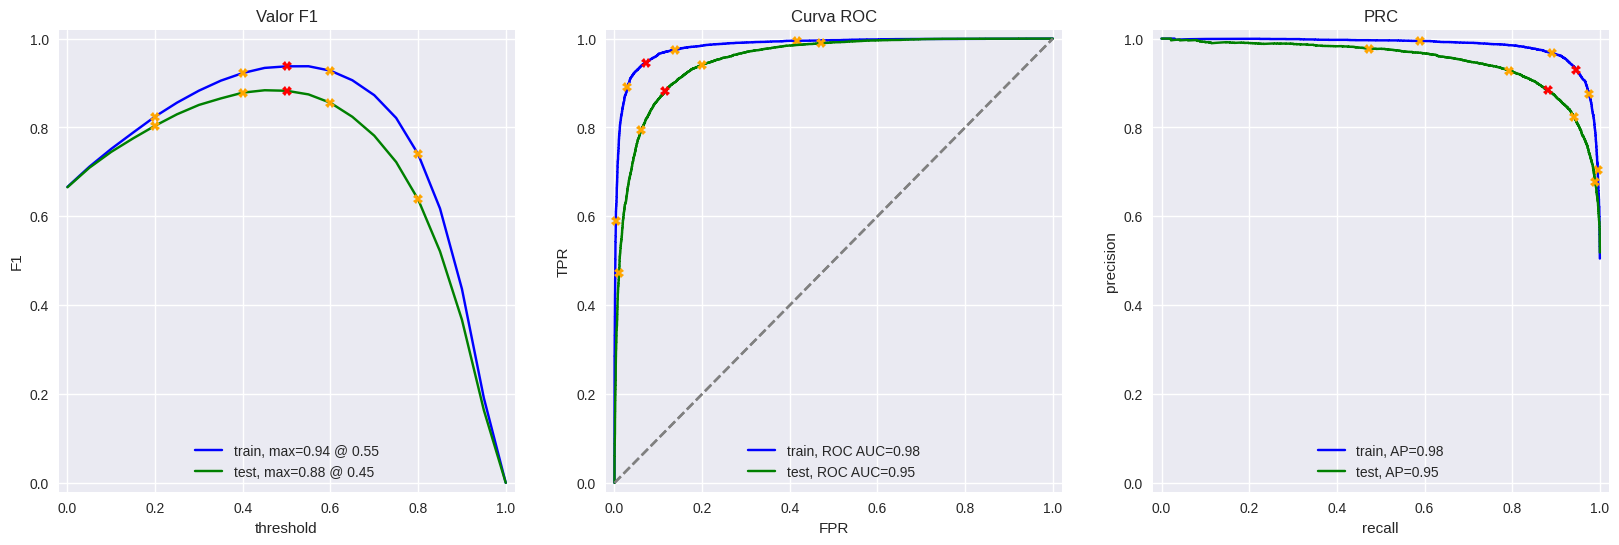

In [23]:
#Evaluar el modelo 
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Modelo 3 - spaCy, TF-IDF y LR

In [24]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [26]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [27]:
#1ro paso: Inicialización 
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

#2do paso: aplicar lemma en el dataset de entrenamiento
df_reviews_train['review_tokenized_3'] = df_reviews_train['review_norm'].apply(lambda x: text_preprocessing_3(x))

#3er paso: Aplicar lemma en el dataset de prueba 
df_reviews_test['review_tokenized_3'] = df_reviews_test['review_norm'].apply(lambda x: text_preprocessing_3(x))

In [28]:
#4to paso: Visualización del cambio en el datset tanto de entreneamiento y prueba 
df_reviews_train['review_tokenized_3'].sample(5)

20112    hubert selby jr give we the book requiem for a...
18143    this be talk about to death by the critic when...
10959    this movie have such inexorable b class cheapn...
18780    this film really disappoint I the acting be at...
9445     contain some spoiler this movie be cheesy s ho...
Name: review_tokenized_3, dtype: object

In [29]:
df_reviews_test['review_tokenized_3'].sample(5)

38838    this movie be awful beyond belief it be a low ...
13318    christopher nolan 's first directorial effort ...
43710    drab dreary and a total waste of my time the p...
19479    this be a excellent back when it come out it h...
45560    why do c thomas howell do these movie cruise h...
Name: review_tokenized_3, dtype: object

In [30]:
#5to paso: Vectorizar el conjunto de prueba y el de entrenamiento 
tfidf_vectorizer_3 = TfidfVectorizer()

train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_tokenized_3'])

test_features_3 = tfidf_vectorizer_3.transform(df_reviews_test['review_tokenized_3'])

print(f'El tamaño de train features de este modelo es: {train_features_3.shape}')
print(f'El tamaño de test features de este modelo es: {train_features_3.shape}')

El tamaño de train features de este modelo es: (23796, 59276)
El tamaño de test features de este modelo es: (23796, 59276)


In [31]:
#6to paso: Hacer el modelo LR y entrenarlo 
model_3 = LogisticRegression(max_iter=1000)
model_3.fit(train_features_3, train_target)

LogisticRegression(max_iter=1000)

           train  test
Exactitud    NaN   NaN
F1          0.93  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


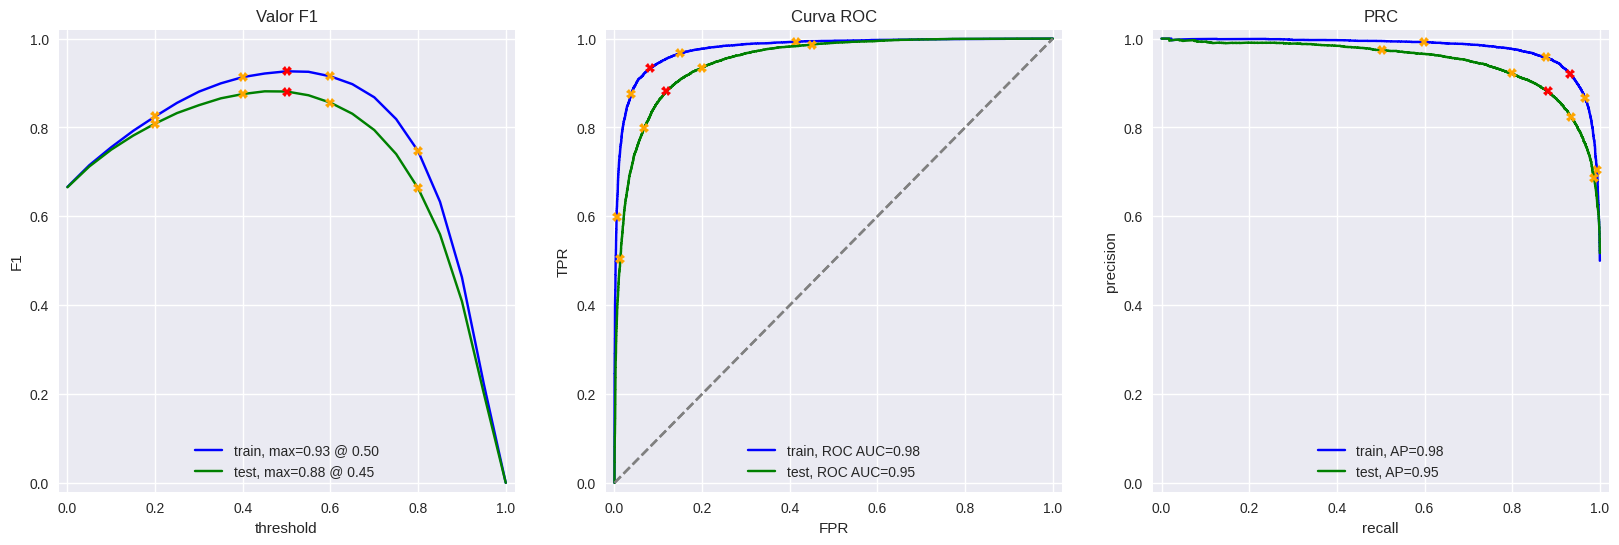

In [32]:
#7to paso: Evaluar el modelo 
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [33]:
from lightgbm import LGBMClassifier

In [34]:
%%time 
model_4 = LGBMClassifier(learning_rate=.1)
model_4.fit(train_features_3, train_target)

CPU times: user 31.2 s, sys: 143 ms, total: 31.4 s
Wall time: 31.4 s


LGBMClassifier()

           train  test
Exactitud    NaN   NaN
F1          0.92  0.86
APS         0.98  0.94
ROC AUC     0.98  0.94


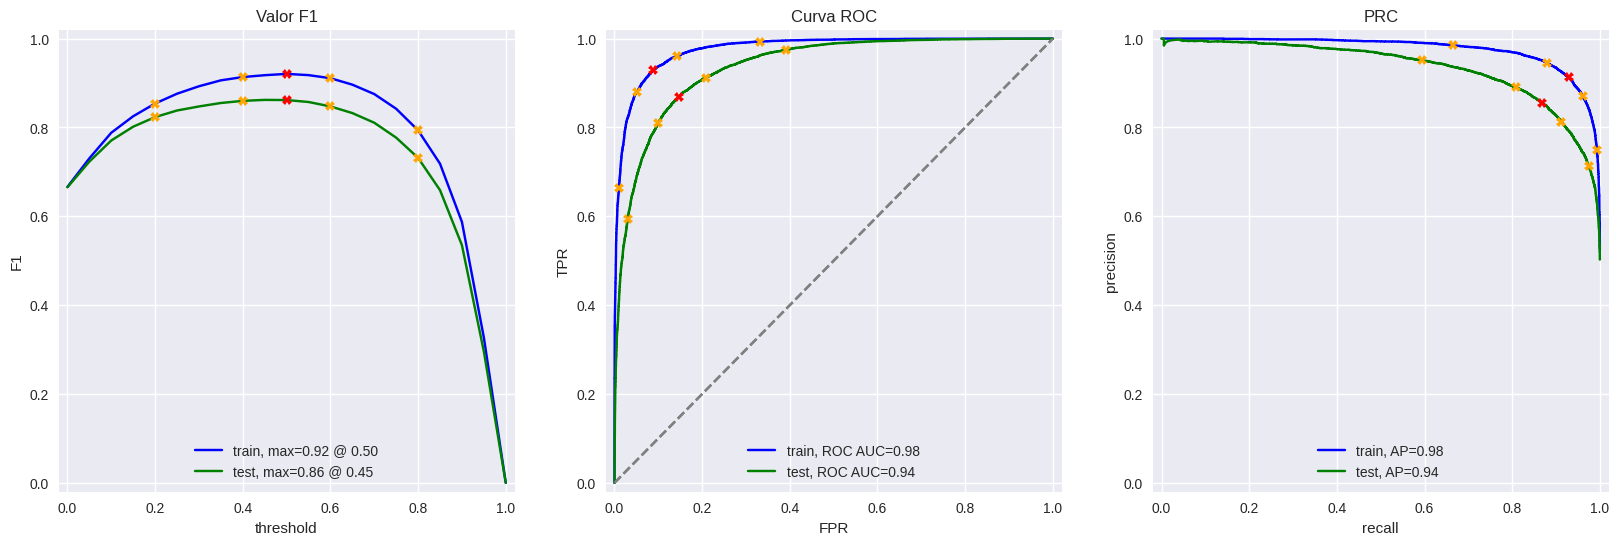

In [35]:
# Evaluar el modelo para F1, APS, ROC-AUC
evaluate_model(model_4, train_features_3, train_target, test_features_3, test_target)

###  Modelo 9 - BERT

In [37]:
import torch
import transformers

In [38]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [39]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    ids_list = []
    attention_mask_list = []

    # Preparar las IDs y las máscaras de atención
    for input_text in tqdm(texts, disable=disable_progress_bar):
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0] * (max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    # Convertir listas a arrays NumPy
    ids_array = np.array(ids_list)
    attention_mask_array = np.array(attention_mask_list)

    # Configurar el dispositivo
    device = torch.device(force_device if force_device else ('cuda' if torch.cuda.is_available() else 'cpu'))
    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')

    # Obtener embeddings en lotes
    embeddings = []
    for i in tqdm(range(math.ceil(len(ids_array) / batch_size)), disable=disable_progress_bar):
        ids_batch = torch.tensor(ids_array[batch_size * i:batch_size * (i + 1)], dtype=torch.long).to(device)
        attention_mask_batch = torch.tensor(attention_mask_array[batch_size * i:batch_size * (i + 1)], 
                                            dtype=torch.long).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:, 0, :].cpu().numpy())

    return np.concatenate(embeddings)

In [40]:
print("¿CUDA disponible?:", torch.cuda.is_available())
print("Dispositivo en uso:", torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

¿CUDA disponible?: False
Dispositivo en uso: cpu


In [ ]:
# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cpu')

  0%|          | 0/23796 [00:00<?, ?it/s]

Uso del dispositivo cpu.


  0%|          | 0/238 [00:00<?, ?it/s]

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

In [ ]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# y cargar...
with np.load('features_9.npz') as data:
    train_features_9 = data['train_features_9']
    test_features_9 = data['test_features_9']

## Mis reseñas

In [41]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] =my_reviews['review'].apply(lambda x: text_preprocessing_3(x)) # <escribe aquí la misma lógica de normalización que para el conjunto de datos principal>

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.","I do not simply like it , not my kind of movie ."
1,"Well, I was bored and felt asleep in the middl...","well , I be bored and feel asleep in the middl..."
2,I was really fascinated with the movie,I be really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actor look really old and disinterest...
4,I didn't expect the reboot to be so good! Writ...,I do not expect the reboot to be so good ! wri...
5,"The movie had its upsides and downsides, but I...","the movie have its upside and downside , but I..."
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy . not a sing...
7,Launching on Netflix was a brave move & I real...,launch on Netflix be a brave move & I really a...


### Modelo 2

In [42]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfid_vectorizer.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  I do not simply like it , not my kind of movie .
0.27:  well , I be bored and feel asleep in the middle of the movie .
0.54:  I be really fascinated with the movie
0.16:  even the actor look really old and disinterested , and they get pay to be in the movie . what a soul
0.28:  I do not expect the reboot to be so good ! writer really care about the source material
0.55:  the movie have its upside and downside , but I feel like overall it be a decent flick . I could see 
0.03:  what a rotten attempt at a comedy . not a single joke land , everyone act annoying and loud , even k
0.82:  launch on Netflix be a brave move & I really appreciate be able to binge on episode after episode , 


### Modelo 3

In [43]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  I do not simply like it , not my kind of movie .
0.20:  well , I be bored and feel asleep in the middle of the movie .
0.49:  I be really fascinated with the movie
0.14:  even the actor look really old and disinterested , and they get pay to be in the movie . what a soul
0.19:  I do not expect the reboot to be so good ! writer really care about the source material
0.68:  the movie have its upside and downside , but I feel like overall it be a decent flick . I could see 
0.04:  what a rotten attempt at a comedy . not a single joke land , everyone act annoying and loud , even k
0.87:  launch on Netflix be a brave move & I really appreciate be able to binge on episode after episode , 


### Modelo 4

In [44]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.56:  I do not simply like it , not my kind of movie .
0.43:  well , I be bored and feel asleep in the middle of the movie .
0.60:  I be really fascinated with the movie
0.57:  even the actor look really old and disinterested , and they get pay to be in the movie . what a soul
0.47:  I do not expect the reboot to be so good ! writer really care about the source material
0.81:  the movie have its upside and downside , but I feel like overall it be a decent flick . I could see 
0.22:  what a rotten attempt at a comedy . not a single joke land , everyone act annoying and loud , even k
0.80:  launch on Netflix be a brave move & I really appreciate be able to binge on episode after episode , 


### Modelo 9

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusiones

En este proyecto, se analizaron diferentes modelos de clasificación para predecir las reseñas de películas basándose en su polaridad (positiva o negativa).

1. En el Modelo Base (Dummy Classifier):
Este modelo nos sirvió como línea base para comparar los demás modelos.
Obtuvo un desempeño esperado, con métricas cercanas al azar (50% en precisión, F1, APS y ROC-AUC).
2. En el Modelo 1 se implento  TF-IDF y Regresión Logística y en este se obtuvo lo siguiente:
Este mostró un avance significativo con un F1-score de `0.94`en entrenamiento y `0.88` en el conjunto de prueba.
Este evidenció la efectividad de las características textuales procesadas con el modelo TF-IDF para la tarea de clasificación.
3. En el Modelo 3 se implmento la herramienta spaCy, TF-IDF y Regresión Logística y en este se obtuvo lo siguiente:
Al incluir lematización con spaCy, el modelo se mantuvo con métricas similares al modelo 1, con un F1-score de `0.93` en entrenamiento y `0.88` en prueba.
Esto sugiere que el preprocesamiento avanzado (como la lematización) puede no aportar mejoras significativas en ciertos contextos.
4. En el Modelo 4 se implento igual que el Modelo 3, o  sea se utilizo spaCy, TF-IDF, pero en su diferencia fue que se utilizó LGBMClassifier y se obtuvo lo siguiente:
En este modelo se relizo la implementación de LightGBM. En el cual mostró un rendimiento competitivo con un F1-score de `0.92 en entrenamiento y 0.86 en prueba.
Sin embargo, el modelo se quedó ligeramente por detrás de la regresión logística, posiblemente debido a la naturaleza del problema y los datos.
En general, el modelo basado en TF-IDF y regresión logística (modelo 1) demostró ser el más eficiente y confiable en este caso. Esto refuerza la importancia de combinar un preprocesamiento adecuado con modelos simples pero efectivo